<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://drive.google.com/file/d/1KWPc4Pa7u2TWekUvNu9rTSO0U2eOlZA9/view?usp=sharing)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [3]:
# !ls ~/Downloads -la
# !mv ~/Downloads/thumbnails128x128.zip ./

In [4]:
# !unzip -q thumbnails128x128.zip -d flickr_faces/

In [5]:
!ls flickr_faces/thumbnails128x128 | head -n 3

00000
02000
03000


In [6]:
DATA_DIR = 'flickr_faces/thumbnails128x128'

In [7]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision

In [8]:
# dir(torchvision)

In [9]:
def get_dataloader(image_size, batch_size):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    # TODO: resize images, convert them to tensors and build dataloader
    apply_transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.transforms.Resize(image_size),
        ]
    )
    ds = ImageFolder(DATA_DIR, transform=apply_transform)
    data_loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
    return data_loader

In [10]:
image_size = 128
batch_size = 32
train_loader = get_dataloader(image_size, batch_size)

In [11]:
# for batch in train_loader:
#     print(len(batch))

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [12]:
class MyDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        # self.classifier = nn.Sequential(
        #     nn.Conv2d(3, 8, 3), 
        #     nn.MaxPool2d(2), 
        #     nn.ReLU(), 
        #     nn.Conv2d(8, 16, 3), 
        #     nn.MaxPool2d(2), 
        #     nn.ReLU(), 
        #     nn.Conv2d(16, 32, 3),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(), 
        #     nn.Conv2d(32, 64, 3),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 128, 3),
        #     nn.MaxPool2d(2),
        #     nn.ReLU(),
        #     nn.Flatten(),
        #     nn.Linear(128*2*2, 1),
        #     nn.Sigmoid()
        # )

        self.classifier = nn.Sequential(
            # in: 3 x 64 x 64

            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 32 x 32

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 16 x 16

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 8 x 8

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 4 x 4

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1

            nn.Flatten(),
            nn.Linear(25, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.classifier(x)
        return x

In [13]:
discriminator = MyDiscriminator()
discriminator = discriminator.to(device)

In [14]:
class MyGenerator(nn.Module):
    def __init__(self, latent_size, image_size):
        super().__init__()
        self.latent_size = latent_size
        self.image_size = image_size

        # self.generator = nn.Sequential(
        #     nn.ConvTranspose2d(self.latent_size, 128, 3, stride=2),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(128, 64, 3, stride=2),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(64, 32, 3, stride=2),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(32, 16, 3, stride=2),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(16, 8, 3, stride=2),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(8, 3, 3, stride=2, output_padding=1),
        #     nn.Sigmoid()
        # )

        # self.generator = nn.Sequential(
        #     # in: latent_size x 1 x 1

        #     nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
        #     nn.BatchNorm2d(512),
        #     nn.ReLU(True),
        #     # out: 512 x 4 x 4

        #     nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(True),
        #     # out: 256 x 8 x 8

        #     nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(True),
        #     # out: 128 x 16 x 16

        #     nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(True),
        #     # out: 64 x 32 x 32

        #     nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
        #     nn.ConvTranspose2d(3, 3, kernel_size=4, stride=2, padding=1, bias=False),
        #     nn.Tanh()
        # # out: 3 x 64 x 64
        # )

        ngf = 128
        self.generator = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( latent_size, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, ngf // 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf//2),
            nn.ReLU(True),
            # state size. [(ngf) / 2] x 64 x 64

            nn.ConvTranspose2d( ngf // 2, 3, 4, 2, 1, bias=False),
            # state size. (nc) x 128 x 128
            nn.Tanh()
        )

    def forward(self, x):
        x = self.generator(x)
        return x

In [15]:
latent_size = 100 # choose latent size

generator = MyGenerator(latent_size, image_size)
generator = generator.to(device)

In [16]:
random_noise = torch.randn((16, latent_size, 1, 1))

(array([  2.,   4.,  13.,  22.,  49.,  77.,  94., 135., 181., 196., 210.,
        202., 141., 112.,  81.,  37.,  26.,  11.,   4.,   3.]),
 array([-3.26620746, -2.94139028, -2.6165731 , -2.29175591, -1.96693861,
        -1.64212132, -1.31730413, -0.99248695, -0.66766971, -0.3428525 ,
        -0.01803529,  0.30678192,  0.63159913,  0.95641637,  1.28123355,
         1.60605073,  1.93086803,  2.25568533,  2.58050251,  2.90531969,
         3.23013687]),
 <BarContainer object of 20 artists>)

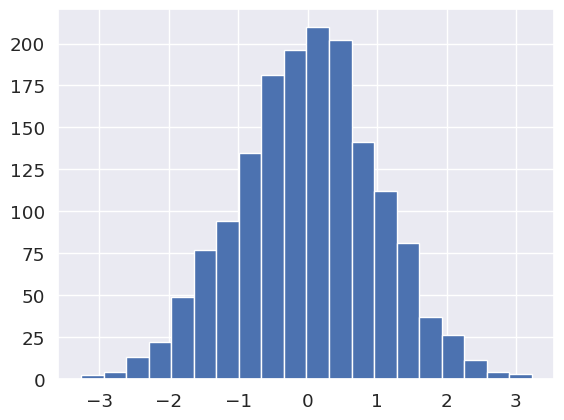

In [17]:
import matplotlib.pyplot as plt
points = []
for i in range(len(random_noise)):
    points_i = random_noise.numpy()[i].squeeze()
    for j in range(len(points_i)):
        points.append(points_i[j])
plt.hist(points, bins=20)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [18]:
discriminator = MyDiscriminator()
discriminator = discriminator.to(device)

generator = MyGenerator(latent_size, image_size)
generator = generator.to(device)

In [19]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [20]:
discriminator.apply(weights_init)
generator.apply(weights_init)

MyGenerator(
  (generator): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13):

In [21]:
lr = 0.001
beta1 = 0.5

model = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [22]:
# def fit(model, criterion, loader, epochs, lr):
#     optimizer = {
#         'discriminator': torch.optim.Adam(model['discriminator'].parameters(), lr=lr, betas=(beta1, 0.999)),
#         'generator': torch.optim.Adam(model['generator'].parameters(), lr=lr, betas=(beta1, 0.999))
#     }
#     model['discriminator'].train()
#     model['generator'].train()

#     for epoch in range(epochs):
#         i = 0
#         for X, _ in loader:
#             i+=1
#             optimizer['discriminator'].zero_grad()
#             batch_size = len(X)
#             real_y = torch.ones(batch_size).to(device)
#             fake_y = torch.zeros(batch_size).to(device)

#             real_images = X.to(device)
#             random_noise = torch.randn((batch_size, latent_size, 1, 1)).to(device)
#             fake_images = model['generator'](random_noise)
            
#             the_batch = torch.concat([real_images, fake_images])
#             the_y = torch.concat([real_y, fake_y])

#             probs = model['discriminator'](the_batch)
#             # print('Probs', probs)
#             discr_loss = criterion['discriminator'](probs, the_y.unsqueeze(1))

#             # print(probs)
#             # print(the_y)
#             # print('------------------')
            
#             discr_loss.backward()
#             optimizer['discriminator'].step()


#             optimizer['generator'].zero_grad()
#             random_noise = torch.randn((batch_size, latent_size, 1, 1)).to(device)
#             generated_fake_images = model['generator'](random_noise)
#             generated_fake_probs = model['discriminator'](generated_fake_images)
#             gen_loss = criterion['generator'](generated_fake_probs, torch.ones(batch_size).to(device).unsqueeze(1))

#             gen_loss.backward()
#             optimizer['generator'].step()

#             if i % 50 == 0:
#                 print(epoch, i, 'Discr loss: ', discr_loss, 'Gen loss: ', gen_loss)


In [23]:
# def fit(model, criterion, epochs, lr, train_dl, start_idx=1):
#     model["discriminator"].train()
#     model["generator"].train()
#     torch.cuda.empty_cache()
    
#     # Losses & scores
#     losses_g = []
#     losses_d = []
#     real_scores = []
#     fake_scores = []
    
#     # Create optimizers
#     optimizer = {
#         "discriminator": torch.optim.Adam(model["discriminator"].parameters(), 
#                                           lr=lr, betas=(0.5, 0.999)),
#         "generator": torch.optim.Adam(model["generator"].parameters(),
#                                       lr=lr, betas=(0.5, 0.999))
#     }
    
#     for epoch in range(epochs):
#         loss_d_per_epoch = []
#         loss_g_per_epoch = []
#         real_score_per_epoch = []
#         fake_score_per_epoch = []
#         for real_images, _ in tqdm(train_dl):
#             real_images = real_images.to(device)
#             # Train discriminator
#             # Clear discriminator gradients
#             optimizer["discriminator"].zero_grad()

#             # Pass real images through discriminator
#             # print(real_images.shape)
#             real_preds = model["discriminator"](real_images)
#             real_targets = torch.ones(real_images.size(0), 1, device=device)
#             real_loss = criterion["discriminator"](real_preds, real_targets)
#             cur_real_score = torch.mean(real_preds).item()
            
#             # Generate fake images
#             latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
#             fake_images = model["generator"](latent)

#             # Pass fake images through discriminator
#             fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
#             # print(fake_images.shape)
#             fake_preds = model["discriminator"](fake_images)
#             fake_loss = criterion["discriminator"](fake_preds, fake_targets)
#             cur_fake_score = torch.mean(fake_preds).item()

#             real_score_per_epoch.append(cur_real_score)
#             fake_score_per_epoch.append(cur_fake_score)

#             # Update discriminator weights
#             loss_d = real_loss + fake_loss
#             loss_d.backward()
#             optimizer["discriminator"].step()
#             loss_d_per_epoch.append(loss_d.item())


#             # Train generator
#             # Clear generator gradients
#             optimizer["generator"].zero_grad()
            
#             # Generate fake images
#             latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
#             fake_images = model["generator"](latent)
            
#             # Try to fool the discriminator
#             preds = model["discriminator"](fake_images)
#             targets = torch.ones(batch_size, 1, device=device)
#             loss_g = criterion["generator"](preds, targets)
            
#             # Update generator weights
#             loss_g.backward()
#             optimizer["generator"].step()
#             loss_g_per_epoch.append(loss_g.item())
            
#         # Record losses & scores
#         losses_g.append(np.mean(loss_g_per_epoch))
#         losses_d.append(np.mean(loss_d_per_epoch))
#         real_scores.append(np.mean(real_score_per_epoch))
#         fake_scores.append(np.mean(fake_score_per_epoch))
        
#         # Log losses & scores (last batch)
#         print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
#             epoch+1, epochs, 
#             losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))
    
#         # Save generated images
#         # if epoch == epochs - 1:
#         #   save_samples(epoch+start_idx, fixed_latent, show=False)
    
#     return losses_g, losses_d, real_scores, fake_scores

In [24]:
def fit(model, criterion, loader, epochs, lr):
    optimizer = {
        'discriminator': torch.optim.Adam(model['discriminator'].parameters(), lr=lr, betas=(beta1, 0.999)),
        'generator': torch.optim.Adam(model['generator'].parameters(), lr=lr, betas=(beta1, 0.999))
    }
    model['discriminator'].train()
    model['generator'].train()

    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    real_label = 1.
    fake_label = 0.

    for epoch in range(epochs):
        for i, data in enumerate(loader, 0):


            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            model['discriminator'].zero_grad()
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            # Forward pass real batch through D
            output = model['discriminator'](real_cpu).view(-1)
            # Calculate loss on all-real batch
            errD_real = criterion['discriminator'](output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, latent_size, 1, 1, device=device)
            # Generate fake image batch with G
            fake = model['generator'](noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = model['discriminator'](fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion['discriminator'](output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizer['discriminator'].step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            model['generator'].zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = model['discriminator'](fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion['generator'](output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizer['generator'].step()

            # Output training stats
            # if iters % 50 == 0:
            #     print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
            #         % (epoch, epochs, i, len(loader),
            #             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            # if (iters % 500 == 0) or ((epoch == epochs-1) and (i == len(loader)-1)):
            #     with torch.no_grad():
            #         fake = netG(fixed_noise).detach().cpu()
            #     # img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

            if iters % 50 == 0:
                print(epoch, iters, 'Discr loss: ', errD.item(), 'Gen loss: ', errG.item())


In [25]:
fit(model, criterion, train_loader, 15, lr)

0 50 Discr loss:  0.04517238214612007 Gen loss:  9.648210525512695
0 100 Discr loss:  0.5594521760940552 Gen loss:  5.6156768798828125
0 150 Discr loss:  0.024254506453871727 Gen loss:  4.429030418395996
0 200 Discr loss:  7.49212121963501 Gen loss:  0.781606912612915
0 250 Discr loss:  0.10724759846925735 Gen loss:  3.978806495666504
0 300 Discr loss:  0.8042110204696655 Gen loss:  2.923552989959717
0 350 Discr loss:  1.0183870792388916 Gen loss:  2.401231288909912
0 400 Discr loss:  1.3957982063293457 Gen loss:  2.0995187759399414
0 450 Discr loss:  1.0711688995361328 Gen loss:  2.2012813091278076
0 500 Discr loss:  1.210418701171875 Gen loss:  3.0963144302368164
0 550 Discr loss:  1.0689682960510254 Gen loss:  2.9851036071777344
0 600 Discr loss:  1.1936694383621216 Gen loss:  3.827116012573242
0 650 Discr loss:  0.9851187467575073 Gen loss:  2.27372670173645
0 700 Discr loss:  0.9818983674049377 Gen loss:  2.928048849105835
0 750 Discr loss:  1.5737330913543701 Gen loss:  3.8616325

In [26]:
# history = fit(model, criterion, 5, lr, train_loader)

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [84]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

In [85]:
from torchvision.utils import save_image

In [86]:
def show_images(generated):
    plt.imshow(generated[0].detach().cpu().numpy().transpose(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


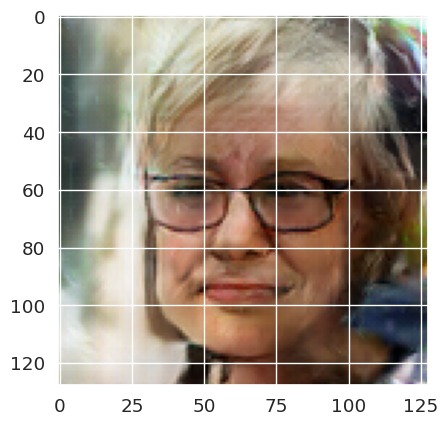

In [87]:
show_images(fake_images)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [98]:
N_images = 65535

In [99]:
batch_size = 128

In [100]:
n_batches = N_images // batch_size

In [101]:
if not os.path.exists('fake_images'):
    os.makedirs('fake_images')

In [102]:
for n_batch in range(n_batches):
    fixed_latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = model["generator"](fixed_latent)
    for i in range(len(fake_images)):
        save_image(fake_images[i], f"fake_images/fake_image_{n_batch*batch_size + i}.png")
    if (n_batch*batch_size + i) % 1000 == 0:
        print(f'saved_{n_batch*batch_size + i}')

In [104]:
torch.save(model['discriminator'].state_dict(), 'discriminator.pt')
torch.save(model['generator'].state_dict(), 'generator.pt')

Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: